In [1]:
!git clone -b unet-gan https://github.com/hoangbros03/GAN-implement.git

Cloning into 'GAN-implement'...
remote: Enumerating objects: 20499, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 20499 (delta 112), reused 209 (delta 86), pack-reused 20258
Receiving objects: 100% (20499/20499), 545.30 MiB | 42.65 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [2]:
import os
os.chdir('GAN-implement/src/cnn_gan')

In [3]:
os.chdir('../pure_gan')
from mnist_dataloader import check_and_process_dataloader

In [4]:
os.chdir('../cnn_gan')
from train import Trainer

In [5]:
dataloader = check_and_process_dataloader("mnist", (1, 28, 28), 32)

The path 'mnist' created successfully.


100%|██████████| 9912422/9912422 [00:00<00:00, 88179973.67it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 130534152.83it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26304566.46it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8444383.32it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [6]:
device = 'cuda'
trainer = Trainer(device=device, generator="mnist", discriminator="mnist", img_size=28, channel=1)
trainer.train_loop(dataloader, num_epochs=5, D_G_train_proportion=3)

100%|██████████| 5/5 [02:22<00:00, 28.46s/it]


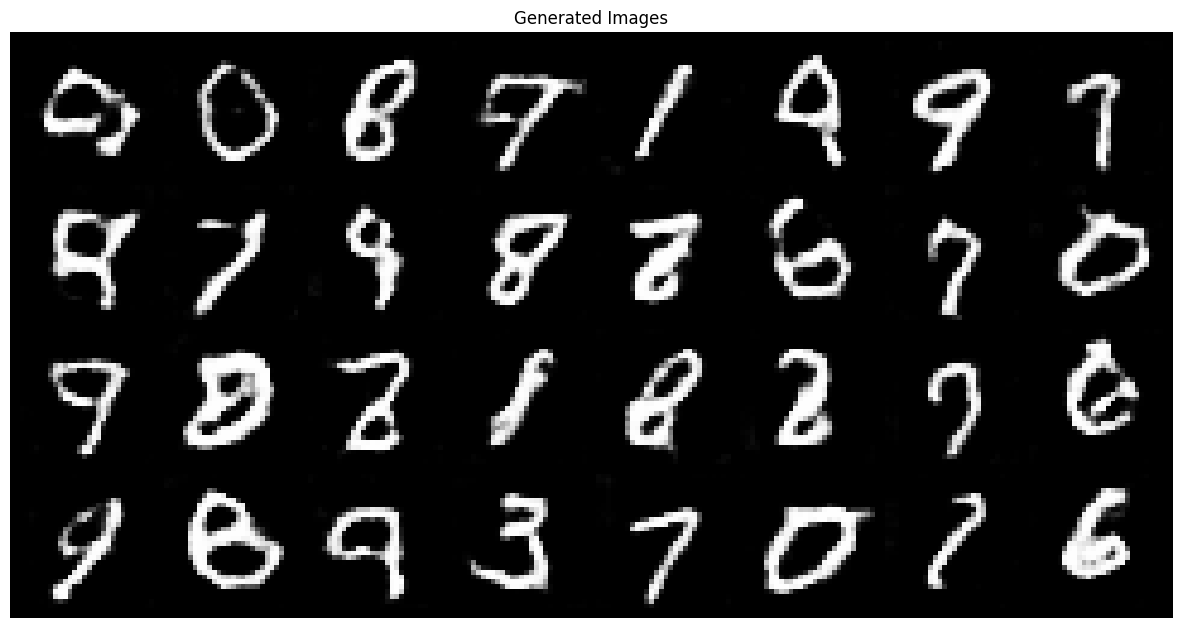

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Plot the fake images from the last epoch
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(trainer.img_list[-1],(1,2,0)))
plt.savefig('mnist')
plt.show()

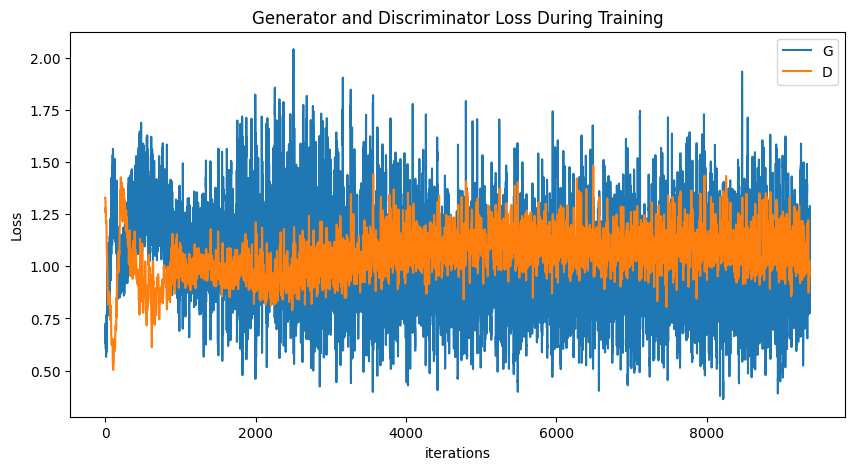

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainer.G_losses,label="G")
plt.plot(trainer.D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()